
# Earnings Event Copilot — Classroom Demo

This notebook demonstrates the core workflow of your **Earnings Event Copilot**:

- Planner → Agents → Prompt Chaining → Routing → Evaluator→Optimizer → Memory
- Generates a **one‑page brief** for a ticker (default: `AAPL`)
- Shows a simple **price chart** (dummy or yfinance if installed)

> It will try to import your project modules if you have the folder structure from class. If not found, it will fall back to lightweight in-notebook versions so it still runs.


In [16]:
'''
# Minimal imports
import sys, json, math, textwrap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

# Try to use yfinance (optional)
try:
    import yfinance as yf
    HAS_YF = True
except Exception:
    HAS_YF = False

import matplotlib.pyplot as plt
'''

## 1) Configuration

In [383]:

# You can change the ticker here for your demo
TICKER = "AAPL"
CFG = {
    "price_history": {"window_days": 120},
    "calendar": {"lookahead_days": 30},
    "news": {"max_articles": 10, "recency_days": 21},
    "routing": {
        "earnings_keywords": ["earnings","EPS","guidance","transcript","beat","miss"],
        "macro_keywords": ["inflation","rates","Fed","unemployment","CPI"],
    },
    "forecast": {"lookahead_days": 5},
    "backtest": {"window_quarters": 8},
    "memory_store": None,  # disabled for notebook demo
}


## 2) Orchestrator import (or fallback stubs)

In [386]:

USING_FALLBACK = False

try:
    # If the project layout exists and is on PYTHONPATH, this will work:
    from agents.orchestrator import Orchestrator
    
except Exception as e:
    USING_FALLBACK = True
    print("Project modules not found — using in-notebook fallback classes.\nReason:", e)





Project modules not found — using in-notebook fallback classes.
Reason: cannot import name 'Orchestrator' from 'agents.orchestrator' (/Users/roshan_thakur/Desktop/University/Natural-Language-Processing/Final-Project/agents/orchestrator.py)


In [84]:
'''
# --- Fallback minimal implementations (mirrors your skeleton) ---
class MarketTool:
    def __init__(self, window_days=120):
        
        self.window_days = window_days
        
        def prices(self, ticker: str) -> pd.DataFrame:
            if 'yf' in sys.modules and HAS_YF:
                df = yf.download(ticker, period=f"{self.window_days}d")
                if not df.empty:
                    return df[["Close"]]
        # Dummy series
        dates = pd.date_range(end=pd.Timestamp.today(), periods=self.window_days)
        close = 100 + np.cumsum(np.random.randn(self.window_days))*0.5
        return pd.DataFrame({"Close": close}, index=dates)
'''


'\n# --- Fallback minimal implementations (mirrors your skeleton) ---\nclass MarketTool:\n    def __init__(self, window_days=120):\n        \n        self.window_days = window_days\n        \n        def prices(self, ticker: str) -> pd.DataFrame:\n            if \'yf\' in sys.modules and HAS_YF:\n                df = yf.download(ticker, period=f"{self.window_days}d")\n                if not df.empty:\n                    return df[["Close"]]\n        # Dummy series\n        dates = pd.date_range(end=pd.Timestamp.today(), periods=self.window_days)\n        close = 100 + np.cumsum(np.random.randn(self.window_days))*0.5\n        return pd.DataFrame({"Close": close}, index=dates)\n'

**PriceHistoryProvider:** fetches recent prices (with yfinance if available) and otherwise creates a dummy series.

In [388]:
import sys, importlib
import numpy as np
import pandas as pd

# Try yfinance
try:
    import price_history_provider as yf
    HAS_YF = True
except Exception as e:
    HAS_YF = False
    print("yfinance not available in this kernel:", repr(e))

class PriceHistoryProvider:
    def __init__(self, window_days: int = 120):
        self.window_days = window_days

    def prices(self, ticker: str) -> pd.DataFrame:
        print(f"[PriceHistoryProvider] prices() called for {ticker} | HAS_YF={HAS_YF}")

        if HAS_YF:
            try:
                finance_df = yf.download(ticker, period=f"{self.window_days}d", progress=False)
                print("Printing the finance_df data now…..")
                print(finance_df.head(5))
                if isinstance(finance_df, pd.DataFrame) and not finance_df.empty and "Close" in finance_df.columns:
                    out = finance_df[["Close"]].copy()
                    # optional timezone normalize
                    if hasattr(out.index, "tz_localize"):
                        try:
                            out.index = out.index.tz_localize(None)
                        except Exception:
                            pass
                    return out
                else:
                    print("[PriceHistoryProvider] yfinance returned empty/invalid DF — falling back to dummy series.")
            except Exception as e:
                print("[PriceHistoryProvider] yfinance download error — falling back to dummy series:", repr(e))
        else:
            print("[PriceHistoryProvider] HAS_YF is False — using dummy series fallback.")

        # Fallback: dummy series (always prints so you see it ran)
        rng = np.random.default_rng(0)  # deterministic for demos
        dates = pd.date_range(end=pd.Timestamp.today().normalize(), periods=self.window_days, freq="D")
        close = 100 + rng.normal(0, 0.5, size=self.window_days).cumsum()
        dummy = pd.DataFrame({"Close": close}, index=dates)
        print("Dummy series preview:")
        print(dummy.head(5))
        return dummy


In [390]:
hist_price = PriceHistoryProvider(window_days=30)
df = hist_price.prices("AAPL")    # you should see prints from inside prices()
print("\nReturned DF preview:")
display(df.head(3))

[PriceHistoryProvider] prices() called for AAPL | HAS_YF=True


/var/folders/q9/1nqnzmps1ml7_3d1x01dm2540000gn/T/ipykernel_98123/2902241399.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  finance_df = yf.download(ticker, period=f"{self.window_days}d", progress=False)


Printing the finance_df data now…..
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-08-28  232.559998  233.410004  229.339996  230.820007  38074700
2025-08-29  232.139999  233.380005  231.369995  232.509995  39418400
2025-09-02  229.720001  230.850006  226.970001  229.250000  44075600
2025-09-03  238.470001  238.850006  234.360001  237.210007  66427800
2025-09-04  239.779999  239.899994  236.740005  238.449997  47549400

Returned DF preview:


Price,Close
Ticker,AAPL
Date,
2025-08-28,232.559998
2025-08-29,232.139999
2025-09-02,229.720001


**PriceHistoryProvider** pulls the prices for a ticker.  
**EarningsCalendarProvider** tells us when the event happens (the next/past earnings dates).  

**Why EarningsCalendarProvider matters**

It keeps our analysis anchored to when things happen. Once we know the exact report day, we can look at the right slice of data, avoid peeking into the future, and time your checks.  

**Time-aware views:** Look at pre-earnings (T-7 to T-1) and post-earnings (T to T+5) windows to see what typically happens before and after the report.  
**No look-ahead bias:** Only use data available up to the event when analyzing or forecasting.  
**Smarter workflow:** As the earnings date approaches, company-specific info matters more. So the agent:  
a) Speeds up data gathering (check news/guidance more often, pull transcripts/whispers).   
b) Prioritizes the Earnings Analyzer (looks for beats/misses, guidance tone, margin talk).   
c) De-emphasizes Macro Analyzer (inflation/Fed stories) unless a macro headline is truly dominant.(macro = the background weather of the market; micro = the company’s own news)  

**Backtests:** The idea is to use only what was knowable at the time and test the same simple rule across many past earnings events (T₁, T₂, …) for a ticker. That tells us whether our logic tends to help or hurt. It will build a timeline of past earnings (T₁, T₂, …) to compute hit-rate, worst loss, average 1–5 day move, drift, gap size, etc.  

**Richer features:** Add event-aware features like days-to-earnings, pre-event volatility, event-day gap, and guidance tone to make earnings analysis smarter. Here’s what each signal means, how to compute it, and where it fits in the pipeline.


1) Days-to-Earnings (timing signal)

What it is: How many calendar/trading days until the next earnings event.
Why it matters: Behavior shifts as the event approaches (rumors, positioning).
Compute (before the event)

2) Pre-Event Volatility (risk/energy signal)

What it is: Realized volatility in a lookback window before T (e.g., T−21…T−1).
Why it matters: Higher pre-event vol often means bigger post-event moves (more uncertainty).

3) Event-Day Gap (surprise/impact signal)

What it is: The jump from T−1 close to T open (for after-hours reports).
Why it matters: Captures the “instant surprise” the market prices in.

4) Guidance Tone (semantic signal)

What it is: Whether management raised/lowered/maintained outlook (and how strongly).
Why it matters: Guidance often drives medium-term narrative beyond a single quarter.

Extract (simple keyword model):

Clear briefs: “Next earnings: Oct 23, 2025 (in 6 days)” sets expectations and frames risk for the reader.

**EarningsCalendarProvider** is a small, fault-tolerant service for finding earnings dates for a stock ticker. It tries multiple sources in order, normalizes timezones, and gives you convenient queries like “next earnings,” “last N earnings,” “upcoming K,” and “events in a window.”  

**Data sources (in order)**  

**yfinance (if installed):** calls yf.Ticker(ticker).get_earnings_dates(limit=...)  
**User provider (optional)**: a callback you pass in  
(ticker: str, now_utc: datetime, lookahead_days: int) -> Iterable[datetime]  
You can return any mix of past/future datetimes (as datetime or pd.Timestamp).  
**Fallback:** if nothing is found, it returns today + min(7, lookahead_days) to keep pipelines running.  


**Key behaviors & decisions**

Timezone safety: All date/times are converted to UTC (tz-aware) whether they came from yfinance or your provider.

Lookahead window: lookahead_days defines a window [now, now+lookahead]. If prefer_window=True, the provider picks an upcoming date inside this window when multiple are available; otherwise it picks the earliest upcoming.

Graceful failure: Every step is wrapped in try/except so bad data, missing yfinance, or provider errors won’t crash your pipeline.

Return types:

next_earnings(...) -> str returns an ISO date string (date-only) for easy display/logging.

All other methods return list[datetime] (UTC) so you can do time arithmetic.

Public API

next_earnings(ticker) -> str
Next upcoming earnings date (ISO YYYY-MM-DD), with the 3-stage fallback.

all_earnings(ticker, limit=32) -> list[datetime]
Up to limit past+future events (UTC), sorted ascending.

past_earnings(ticker, n=8, ref=None) -> list[datetime]
The last n events ≤ ref (default now).

upcoming_earnings(ticker, k=1, ref=None) -> list[datetime]
The next k events > ref (default now).

events_between(ticker, start, end) -> list[datetime]
All events in [start, end] (inclusive), in UTC.

In [392]:

# import necessary libraries
from __future__ import annotations
from datetime import datetime, timedelta, timezone
from typing import Callable, Iterable, Optional
import pandas as pd

# yfinance for real earnings dates
try:
    import price_history_provider as yf
    HAS_YF = True
except Exception:
    HAS_YF = False


class EarningsCalendarProvider:
    """
    Earnings date lookup with sensible fallbacks.

    Order of operations:
      1) Try yfinance (if available).
      2) Try an optional user-supplied provider function (if given).
      3) Fallback: return today+min(7, lookahead_days) to keep the pipeline running.

    A "provider function" should be:  (ticker: str, now_utc: datetime, lookahead_days: int) -> Iterable[datetime]
    It returns one or more candidate datetimes (past or future). We'll pick the next upcoming one.
    """

    def __init__(
        self,
        lookahead_days: int = 30,
        provider: Optional[Callable[[str, datetime, int], Iterable[datetime]]] = None,
        prefer_window: bool = True,
    ):
        self.lookahead_days = int(lookahead_days)
        self.provider = provider
        self.prefer_window = prefer_window  # prefer a date within lookahead window if multiple upcoming exist

    # ---------- public API ----------
    def next_earnings(self, ticker: str) -> str:
        now = datetime.now(timezone.utc)
        window_end = now + timedelta(days=self.lookahead_days)

        # 1) yfinance
        dt = self._from_yfinance(ticker, now, window_end)
        if dt:
            return dt.date().isoformat()

        # 2) user provider
        dt = self._from_provider(ticker, now, window_end)
        if dt:
            return dt.date().isoformat()

        # 3) fallback
        days = min(7, self.lookahead_days)
        return (now + timedelta(days=days)).date().isoformat()

    # ---------- internal helpers ----------
    def _from_yfinance(self, ticker: str, now_utc: datetime, window_end: datetime) -> Optional[datetime]:
        if not HAS_YF:
            return None
        try:
            df = yf.Ticker(ticker).get_earnings_dates(limit=24)
            if df is None or df.empty:
                return None

            # yfinance returns DatetimeIndex; make sure it's tz-aware UTC
            idx = df.index
            if getattr(idx, "tz", None):
                idx = idx.tz_convert("UTC")
            else:
                idx = idx.tz_localize("UTC")

            upcoming = [d.to_pydatetime() for d in idx if d >= now_utc]
            if not upcoming:
                return None

            if self.prefer_window:
                in_win = [d for d in upcoming if d <= window_end]
                if in_win:
                    return sorted(in_win)[0]
            return sorted(upcoming)[0]
        except Exception:
            return None

    def _from_provider(self, ticker: str, now_utc: datetime, window_end: datetime) -> Optional[datetime]:
        if not self.provider:
            return None
        try:
            candidates = list(self.provider(ticker, now_utc, self.lookahead_days) or [])
            if not candidates:
                return None

            # normalize to UTC-aware datetimes
            norm: list[datetime] = []
            for d in candidates:
                if isinstance(d, pd.Timestamp):
                    if d.tzinfo is None:
                        d = d.tz_localize("UTC").to_pydatetime()
                    else:
                        d = d.tz_convert("UTC").to_pydatetime()
                elif isinstance(d, datetime) and d.tzinfo is None:
                    d = d.replace(tzinfo=timezone.utc)
                norm.append(d)

            upcoming = [d for d in norm if d >= now_utc]
            if not upcoming:
                return None

            if self.prefer_window:
                in_win = [d for d in upcoming if d <= window_end]
                if in_win:
                    return sorted(in_win)[0]
            return sorted(upcoming)[0]
        except Exception:
            return None


    def all_earnings(self, ticker: str, limit: int = 32) -> List[datetime]:
        """
        Return up to `limit` earnings datetimes (UTC) for this ticker, past and future, sorted ascending.
        """
        dates: List[datetime] = []
        # 1) yfinance
        if HAS_YF:
            try:
                df = yf.Ticker(ticker).get_earnings_dates(limit=limit)
                if df is not None and not df.empty:
                    idx = df.index
                    if getattr(idx, "tz", None):
                        idx = idx.tz_convert("UTC")
                    else:
                        idx = idx.tz_localize("UTC")
                    dates = [d.to_pydatetime() for d in idx]
            except Exception:
                dates = []

        # 2) user provider (if you want it to also supply past dates)
        if not dates and self.provider:
            try:
                now = datetime.now(timezone.utc)
                candidates = list(self.provider(ticker, now, self.lookahead_days) or [])
                # Normalize like before
                norm: List[datetime] = []
                for d in candidates:
                    if isinstance(d, pd.Timestamp):
                        d = (d.tz_localize("UTC") if d.tzinfo is None else d.tz_convert("UTC")).to_pydatetime()
                    elif isinstance(d, datetime) and d.tzinfo is None:
                        d = d.replace(tzinfo=timezone.utc)
                    norm.append(d)
                dates = norm
            except Exception:
                pass

        return sorted(dates)

    # -------- NEW: last N past earnings up to a ref time --------

    def past_earnings(self, ticker: str, n: int = 8, ref: Optional[datetime] = None) -> List[datetime]:
        """
        Return the last `n` earnings datetimes <= ref (UTC). Default ref = now.
        """
        ref = ref or datetime.now(timezone.utc)
        dates = [d for d in self.all_earnings(ticker, limit=max(32, n*2)) if d <= ref]
        return dates[-n:]   
        

    # -------- NEW: next K upcoming earnings after a ref time --------
    def upcoming_earnings(self, ticker: str, k: int = 1, ref: Optional[datetime] = None) -> List[datetime]:
        """
        Return the next `k` earnings datetimes > ref (UTC). Default ref = now.
        """
        ref = ref or datetime.now(timezone.utc)
        future = [d for d in self.all_earnings(ticker) if d > ref]
        return future[:k]

    # -------- NEW: events in a date window --------
    def events_between(self, ticker: str, start: datetime, end: datetime) -> List[datetime]:
        """
        Return all earnings events in [start, end] (UTC).
        """
        start = start.astimezone(timezone.utc)
        end = end.astimezone(timezone.utc)
        return [d for d in self.all_earnings(ticker, limit=64) if start <= d <= end]


In [225]:
#!pip install tzdata
#!pip install backports.zoneinfo

In [394]:
ct = EarningsCalendarProvider()
ct.next_earnings('AAPL')
#ct.past_earnings('AAPL')

'2025-10-30'

In [396]:
cal = EarningsCalendarProvider()
readable = cal.past_earnings("AAPL", n=4)
print("Past 4:")
for line in readable:
    print(" -", line)

Past 4:
 - 2024-10-31 20:00:00+00:00
 - 2025-01-30 21:00:00+00:00
 - 2025-05-01 20:00:00+00:00
 - 2025-07-31 20:00:00+00:00


In [398]:
from datetime import datetime, timezone

# 1) Plain yfinance + fallback
ec = EarningsCalendarProvider(lookahead_days=45, prefer_window=True)
print("Next:", ec.next_earnings("AAPL"))
display("Past 4:", ec.past_earnings("AAPL", n=4))
print("\n")
display("Upcoming 2:", ec.upcoming_earnings("AAPL", k=2))

# 2) With a custom provider (e.g., your own DB or API cache)
def my_provider(ticker, now_utc, lookahead_days):
    # Return any iterable of datetimes (tz-aware or naive; naive will be set to UTC)
    return [
        datetime(2025, 1, 27, 21, 0, tzinfo=timezone.utc),
        datetime(2025, 4, 28, 21, 0, tzinfo=timezone.utc),
    ]

ec2 = EarningsCalendarProvider(lookahead_days=60, provider=my_provider)
print("Next via provider:", ec2.next_earnings("MSFT"))


Next: 2025-10-30


'Past 4:'

[datetime.datetime(2024, 10, 31, 20, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2025, 1, 30, 21, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2025, 5, 1, 20, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2025, 7, 31, 20, 0, tzinfo=datetime.timezone.utc)]

'Upcoming 2:'

[datetime.datetime(2025, 10, 30, 20, 0, tzinfo=datetime.timezone.utc)]

Next via provider: 2025-10-29


In [277]:
'''
class CompanyNewsProvider:
    
    def __init__(self, max_articles=10, recency_days=21):
        self.max_articles = max_articles;
        self.recency_days = recency_days
        
    def fetch(self, ticker: str):
        rows =  [
            {"title": f"{ticker} beats on EPS, raises guidance", "text": "EPS beat by $0.05; revenue +8% YoY", "published_at": "2025-09-20"},
            {"title": f"{ticker} CFO on margins", "text": "CFO expects gross margin to improve next quarter; guidance up", "published_at": "2025-09-21"},
        ]

        df = pd.DataFrame(rows)
        df["published_at"] = pd.to_datetime(df["published_at"], utc=True, errors="coerce")
        df = df.sort_values("published_at").reset_index(drop=True)
        #df["published_local"] = df["published_at"].dt.tz_convert(ZoneInfo("America/Los_Angeles"))
        #display(df[["published_at","title","text"]])
        pd.set_option("display.max_colwidth", 120)
        return df
'''

Self Explanatory

News & Transcript Agent: This is the ingestion step of the Prompt Chaining pipeline (Ingest → Preprocess → Classify → Extract → Summarize).

Routing: Clean text + timestamps help decide “earnings analyzer vs macro analyzer.”

Features: You’ll extract guidance tone, earnings keywords, and recency windows relative to the earnings date.

Quality/Evaluator: Having a consistent schema (DataFrame) makes it easy to add checks (missing dates, duplicates).

In [400]:
import pandas as pd
from typing import Literal, Optional

class CompanyNewsProvider:
    def __init__(self, mode: Literal["mock","live"]="mock",
                 max_articles: int = 10, recency_days: int = 21,
                 api_key: Optional[str] = None):
        self.mode = mode
        self.max_articles = max_articles
        self.recency_days = recency_days
        self.api_key = api_key

    def fetch(self, ticker: str) -> pd.DataFrame:
        try:
            if self.mode == "live":
                df = self._fetch_live(ticker)   # implement your real API call here
            else:
                df = self._fetch_mock(ticker)
        except Exception:
            # Fail safe: keep the demo flowing
            df = self._fetch_mock(ticker)

        # Normalize
        df["published_at"] = pd.to_datetime(df["published_at"], utc=True, errors="coerce")
        df = df.sort_values("published_at").head(self.max_articles).reset_index(drop=True)
        return df

    def _fetch_mock(self, ticker: str) -> pd.DataFrame:
        rows = [
            {"title": f"{ticker} beats on EPS, raises guidance",
             "text": "EPS beat by $0.05; revenue +8% YoY",
             "published_at": "2025-09-20"},
            {"title": f"{ticker} CFO on margins",
             "text": "CFO expects gross margin to improve next quarter; guidance up",
             "published_at": "2025-09-21"},
        ]
        return pd.DataFrame(rows)

    def _fetch_live(self, ticker: str) -> pd.DataFrame:
        # Pseudo-code; keep output columns identical to _fetch_mock
        # rows = call_your_api(ticker, self.api_key, self.recency_days, self.max_articles)
        # return pd.DataFrame(rows)
        raise NotImplementedError("Wire your real news API here.")


In [402]:
newsProv = CompanyNewsProvider()
newsProv.fetch('AAPL')

,title,text,published_at
0,"AAPL beats on EPS, raises guidance",EPS beat by $0.05; revenue +8% YoY,2025-09-20 00:00:00+00:00
1,AAPL CFO on margins,CFO expects gross margin to improve next quarter; guidance up,2025-09-21 00:00:00+00:00


**EarningsTranscriptProvider:** pulls the earnings call transcript.  
Input: ticker, optional quarter_hint  
Output: pd.DataFrame rows like: section, speaker, text, quarter  
Timing: Point-in-time (event day/quarter)  
Typical signals: guidance tone, margins, demand, one-off disclosures  
Role in routing: Primarily earnings-focused content  
Current mode: Mock rows (easy to swap to real source)  

In [470]:
import pandas as pd
from typing import Callable, Iterable, Optional, Dict, Any

class EarningsTranscriptProvider:
    def __init__(
        self,
        mode: str = "mock",  # "mock" or "live"
        provider: Optional[Callable[[str, Optional[str]], Iterable[Dict[str, Any]]]] = None
    ):
        self.mode = mode
        self.provider = provider  # returns rows of {ticker, quarter, section, speaker, text}

    def fetch(self, ticker: str, quarter_hint: str | None = None) -> pd.DataFrame:
        try:
            if self.mode == "live" and self.provider is not None:
                rows = list(self.provider(ticker, quarter_hint))
            else:
                rows = self._mock_rows(ticker, quarter_hint)
        except Exception:
            # keep the pipeline running even if the live provider fails
            rows = self._mock_rows(ticker, quarter_hint)

        df = pd.DataFrame(rows)
        # optional: enforce column order / fill missing
        needed = ["ticker","quarter","section","speaker","text"]
        for c in needed:
            if c not in df.columns: df[c] = None
        return df[needed].reset_index(drop=True)

    def _mock_rows(self, ticker: str, quarter_hint: str | None) -> list[Dict[str, Any]]:
        q = quarter_hint or "Q3 2025"
        return [
            {"ticker": ticker, "quarter": q, "section": "Prepared Remarks", "speaker": "CEO",
             "text": "Strong demand across regions."},
            {"ticker": ticker, "quarter": q, "section": "Prepared Remarks", "speaker": "CFO",
             "text": "Margins expanding; guidance raised."},
        ]


In [472]:
tt = EarningsTranscriptProvider()
tt.fetch('AAPL')

,ticker,quarter,section,speaker,text
0,AAPL,Q3 2025,Prepared Remarks,CEO,Strong demand across regions.
1,AAPL,Q3 2025,Prepared Remarks,CFO,Margins expanding; guidance raised.


**PromptChain():** Builds the small pipeline that cleans news text, classifies it (earnings/macro/noise), extracts simple facts, and produces a summary.

**Functions included:**
 
**ingest(self, items):** 

“Pass-through” to let the input go through unchanged and normalize them(different sources call things different names headline, body, date) up front so the rest of your pipeline doesn’t need special cases. For example, make sure each item has:

title (string)
text (string)
published_at (UTC datetime)

**preprocess(self, items):** normalize whitespace in text.  

**classify**: Defines two keyword sets:

**earnings_kw:** words that usually mean company-specific earnings news.  
**macro_kw:** words that usually mean economy-wide (macroeconomic) news.  

Loops over items (each it is a dict with at least a "text" field).

In [551]:
import pandas as pd

class PromptChain:
   
    def ingest(self, items):
        # Accept list[dict] or a pandas.DataFrame; coerce to list[dict]
        try:
            if hasattr(items, "to_dict") and isinstance(items, pd.DataFrame):
                items = items.to_dict("records")
                print("items:",items)
        except Exception:
            pass
        return items

    def preprocess(self, items):
        for item in items:
            item["title"] = item.get("title") or ""
            txt = item.get("text") or ""
            item["text"] = " ".join(str(txt).split())  # collapse whitespace
        return items  # <-- moved outside the loop

    def classify(self, items):
        earnings_kw = ("eps","guidance","beat","miss","margin")
        macro_kw    = ("inflation","rates","fed","macro")
        for item in items:
            item_text = (item.get("text") or "").lower()
            if any(keyword in item_text for keyword in earnings_kw):
                item["category"] = "earnings"
            elif any(keyword in item_text for keyword in macro_kw):
                item["category"] = "macro"
            else:
                item["category"] = "noise"
        return items

    def extract(self, items):
        for item in items:
            item_text = (item.get("text") or "").lower()
            facts = {
                "beat": "beat" in item_text,
                "guidance_up": ("guidance" in item_text) and (" up" in item_text or " raise" in item_text or "raised" in item_text),
            }
            item["facts"] = facts
        return items

    def summarize(self, items):
        lines, rows = [], []
        for item in items:
            cat = item.get("category", "?")
            title = item.get("title", "").strip() or "(no title)"
            facts = item.get("facts", {})
            beat = facts.get("beat", False)
            gup  = facts.get("guidance_up", False)
            #lines.append(f"- ({cat}) {title} | beat={beat} guidance_up={gup}")
            #rows.append({"date": date, "cat": cat, "title": title, "beat": beat, "gup": gup})
            rows.append({ "cat": cat, "title": title, "beat": beat, "gup": gup})
        #return "\n".join(lines)



        # Default: concise bullets
        lines = []
        for r in rows:
            beat_icon = "✅" if r["beat"] else "•"
            g_icon    = "⬆️" if r["gup"] else ""
            #date      = f"[{r['date']}] " if r["date"] else ""
            lines.append(f"- ({r['cat']}) {r['title']} {beat_icon}{g_icon}".rstrip())
        return "\n".join(lines)



In [553]:
class NewsTranscriptAgent:

    """Pulls company news + transcripts, runs a prompt-chain, returns items + summary + transcript."""
    
    def __init__(self, news_cfg):
        
        self.news = CompanyNewsProvider(**news_cfg); # source of headlines/articles
        self.tx = EarningsTranscriptProvider(); # source of earnings-call transcript text
        self.chain = PromptChain() # ingest → preprocess → classify → extract → summarize
        
    def run(self, ticker: str):
        
        # Fetch news as DataFrame
        arts_df = self.news.fetch(ticker)
        # optional but helpful for quick review
        try:
            print("This is optional....I will delete it before submitting....")
            print(arts_df[["published_at","title"]].head())
        except Exception:
            print(arts_df.head())

        # Convert DF → records for the chain
        records = arts_df.to_dict("records")
        
        # Prompt-chain: ingest → preprocess → classify → extract    
        processed_items = self.chain.extract(
            self.chain.classify(
                self.chain.preprocess(
                    self.chain.ingest(records)
                )
            )
        )

        # Summarize + add transcript (usually a DataFrame too)
        summary = self.chain.summarize(processed_items)
        transcript_df = self.tx.fetch(ticker)
        
        return {"items": processed_items, "summary": summary, "transcript": transcript_df}

    def print_successful(self):
        print("\n NEWS TRANSCRIPT AGENT CLASS RAN SUCCESSFULLY....\n")
       

In [555]:
news_cfg = {"max_articles": 10, "recency_days": 21}
news_transcript_agent = NewsTranscriptAgent(news_cfg)

out = news_transcript_agent.run("AAPL")  # <-- run the agent

print("\nSUMMARY:\n", out["summary"])
print("\nFIRST ITEM:\n", out["items"][0] if out["items"] else "(no items)")
print("\nTRANSCRIPT PREVIEW:\n", out["transcript"].head())
news_transcript_agent.print_successful()


This is optional....I will delete it before submitting....
               published_at                               title
0 2025-09-20 00:00:00+00:00  AAPL beats on EPS, raises guidance
1 2025-09-21 00:00:00+00:00                 AAPL CFO on margins

SUMMARY:
 - (earnings) AAPL beats on EPS, raises guidance ✅
- (earnings) AAPL CFO on margins •⬆️

FIRST ITEM:
 {'title': 'AAPL beats on EPS, raises guidance', 'text': 'EPS beat by $0.05; revenue +8% YoY', 'published_at': Timestamp('2025-09-20 00:00:00+0000', tz='UTC'), 'category': 'earnings', 'facts': {'beat': True, 'guidance_up': False}}

TRANSCRIPT PREVIEW:
   ticker  quarter           section speaker  \
0   AAPL  Q3 2025  Prepared Remarks     CEO   
1   AAPL  Q3 2025  Prepared Remarks     CFO   

                                  text  
0        Strong demand across regions.  
1  Margins expanding; guidance raised.  

 NEWS TRANSCRIPT AGENT CLASS RAN SUCCESSFULLY....



**DataAgent:** It’s the orchestrator for data fetching. Agents decide what to do; providers (tools) do the actual I/O.

DataAgent hides provider details and hands back a clean, minimal bundle (prices, earnings_date) for downstream steps (routing, forecasting, backtests).

In [560]:

#from typing import Dict
#from ..tools.market import PriceHistoryProvider
#from ..tools.calendar import EarningsCalendarProvider

class DataAgent:
    def __init__(self, price_history_cfg, cal_cfg):    
        self.price_history = PriceHistoryProvider(**price_history_cfg)
        self.cal = EarningsCalendarProvider(**cal_cfg)
        
    def run(self, ticker: str):
        df = self.price_history.prices(ticker)
        if df is None or df.empty:
            return {"prices": df, "earnings_date": self.cal.next_earnings(ticker), "warning": "no price data"}
        return {"prices": df, "earnings_date": self.cal.next_earnings(ticker)}


    def print_successful():
        print("\n DATA AGENT CLASS RAN SUCCESSFULLY....\n")



In [562]:
# rule-based dispatcher that decides where to send a piece of text
class Router:
    
    def __init__(self, earnings_keywords, macro_keywords):
        self.ek = earnings_keywords;
        self.mk = macro_keywords
        
    def route(self, text: str):
        tl = text.lower()
        if any(k.lower() in tl for k in self.ek): return "earnings_analyzer"
        if any(k.lower() in tl for k in self.mk): return "macro_analyzer"
        return "ignore_or_general"

**ForecastAgent:** A tiny heuristic forecaster for the next horizon_days (default 5) that looks at news-derived facts and outputs a direction + strength.  

If your news extraction found either an EPS beat or raised guidance forecast up with **moderate** strength.  
If it found both → forecast up with **strong** strength.  
If neither → return a **neutral/weak** signal.  

In [442]:
class ForecastAgent:
    
    def __init__(self, horizon_days=5):
        self.h=horizon_days
        
    def run(self, news_blob, data_blob):

        items = news_blob.get("items", [])
        
        beat = any(it.get("facts", {}).get("beat", False) for it in items)
        guidance_up = any(it.get("facts",{}).get("guidance_up") for it in items)
        direction = 1 if (beat or guidance_up) else 0
        strength = 0.6 if (beat and guidance_up) else 0.3 if (beat or guidance_up) else 0.1
        return {"horizon_days": self.h, "direction": direction, "strength": strength}

    def print_successful(self):
        print("FORECAST AGENT CLASS RAN SUCCESSFULLY....")
        print("\n")

In [444]:
class RiskBacktestAgent:
    
    def __init__(self, window_quarters=8):
        self.w=window_quarters
        
    def run(self, ticker: str, rules: dict):
        hist=[1,0,1,1,0,1,1,1][:self.w]
        hit_rate=sum(hist)/len(hist); worst_loss=-0.08; consistency=round((hit_rate-0.5)/0.2,2)
        return {"window_quarters": self.w, "hit_rate": round(hit_rate,3), "worst_loss": worst_loss, "consistency": consistency}

    def print_successful():
        print("RISKBACK AGENT CLASS RAN SUCCESSFULLY....")
        print("\n")

In [567]:
class EvaluatorOptimizer:
    
    def evaluate(self, report: dict):
        issues=[]; s=report.get("sections",{})
        if not s.get("earnings_summary"): issues.append("missing_earnings_summary")
        if "forecast" not in report: issues.append("missing_forecast")
        if "backtest" not in report: issues.append("missing_backtest")
        return {"quality": max(0.0,1.0-0.25*len(issues)), "issues": issues}
        
    def optimize(self, report: dict, ev: dict):
        for iss in ev.get("issues",[]):
            if iss=="missing_earnings_summary": report.setdefault("sections",{})["earnings_summary"]="(placeholder)"
            if iss=="missing_forecast": report["forecast"]={"direction":0,"strength":0.0,"horizon_days":5}
            if iss=="missing_backtest": report["backtest"]={"hit_rate":0.5,"worst_loss":-0.1,"consistency":0.0}
        report.setdefault("meta",{})["refined"]=True; return report

def build_report(ctx: dict) -> dict:
    return {
        "ticker": ctx["ticker"],
        "sections": {
            "earnings_summary": ctx.get("news_summary",""),
            "transcript_focus": "gross margin; guidance",
            "risk_notes": "watch volatility into day+1",
        },
        "forecast": ctx.get("forecast",{}),
        "backtest": ctx.get("backtest",{}),
        "meta": {"routed_to": ctx.get("routed_to")}
    }

In [569]:
class Orchestrator:
    
    def __init__(self, cfg):
        
        self.data = DataAgent(cfg["price_history"], cfg["calendar"])
        self.nt = NewsTranscriptAgent(cfg["news"])
        self.fore=ForecastAgent(cfg["forecast"]["lookahead_days"])
        self.rb=RiskBacktestAgent(cfg["backtest"]["window_quarters"])
        self.evalopt=EvaluatorOptimizer()
        self.router=Router(cfg["routing"]["earnings_keywords"], cfg["routing"]["macro_keywords"])
        
    def run(self, ticker: str):
        ctx={"ticker": ticker}
        ctx.update(self.data.run(ticker))
        nt=self.nt.run(ticker); ctx.update({"news_items": nt["items"], "news_summary": nt["summary"], "transcript": nt["transcript"]})
        ctx["routed_to"]=self.router.route(ctx.get("news_summary",""))
        ctx["forecast"]=self.fore.run({"items": ctx.get("news_items",[])}, ctx)
        ctx["backtest"]=self.rb.run(ticker, {"rules":"heuristic_v1"})
        ctx["report"]=build_report(ctx)
        ev=self.evalopt.evaluate(ctx["report"]); ctx["report"]=self.evalopt.optimize(ctx["report"], ev); ctx["quality"]=ev["quality"]
        return ctx["report"]

**ORCHESTRATOR**

## 3) Run the pipeline

In [571]:

orch = Orchestrator(CFG)
report = orch.run(TICKER)
print("=== ONE-PAGE BRIEF ===")
print(json.dumps(report, indent=2))


[PriceHistoryProvider] prices() called for AAPL | HAS_YF=True
Printing the finance_df data now…..
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-04-21  192.688339  193.326776  189.346513  192.798071  46742500
2025-04-22  199.252289  201.097762  195.491490  195.641118  52976400
2025-04-23  204.100433  207.492125  202.304825  205.497009  52929200
2025-04-24  207.861206  208.320090  202.444472  204.389708  47311000
2025-04-25  208.768982  209.237836  205.696501  205.866084  38222300


/var/folders/q9/1nqnzmps1ml7_3d1x01dm2540000gn/T/ipykernel_98123/2902241399.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  finance_df = yf.download(ticker, period=f"{self.window_days}d", progress=False)


This is optional....I will delete it before submitting....
               published_at                               title
0 2025-09-20 00:00:00+00:00  AAPL beats on EPS, raises guidance
1 2025-09-21 00:00:00+00:00                 AAPL CFO on margins
=== ONE-PAGE BRIEF ===
{
  "ticker": "AAPL",
  "sections": {
    "earnings_summary": "- (earnings) AAPL beats on EPS, raises guidance \u2705\n- (earnings) AAPL CFO on margins \u2022\u2b06\ufe0f",
    "transcript_focus": "gross margin; guidance",
    "risk_notes": "watch volatility into day+1"
  },
  "forecast": {
    "horizon_days": 5,
    "direction": 1,
    "strength": 0.6
  },
  "backtest": {
    "window_quarters": 8,
    "hit_rate": 0.75,
    "worst_loss": -0.08,
    "consistency": 1.25
  },
  "meta": {
    "routed_to": "earnings_analyzer",
    "refined": true
  }
}


## 4) Quick table of signals

In [573]:

#from caas_jupyter_tools import display_dataframe_to_user

rows = [
    {"Section": "Forecast Direction", "Value": report.get("forecast",{}).get("direction")},
    {"Section": "Forecast Strength", "Value": report.get("forecast",{}).get("strength")},
    {"Section": "Backtest Hit-Rate", "Value": report.get("backtest",{}).get("hit_rate")},
    {"Section": "Backtest Worst Loss", "Value": report.get("backtest",{}).get("worst_loss")},
    {"Section": "Backtest Consistency", "Value": report.get("backtest",{}).get("consistency")},
]

df = pd.DataFrame(rows)
df.head()


,Section,Value
0,Forecast Direction,1.00
1,Forecast Strength,0.60
2,Backtest Hit-Rate,0.75
3,Backtest Worst Loss,-0.08
4,Backtest Consistency,1.25


## 5) Price chart (last ~120 days)

/var/folders/q9/1nqnzmps1ml7_3d1x01dm2540000gn/T/ipykernel_98123/357007061.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period=f"{CFG['price_history']['window_days']}d")
[*********************100%***********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

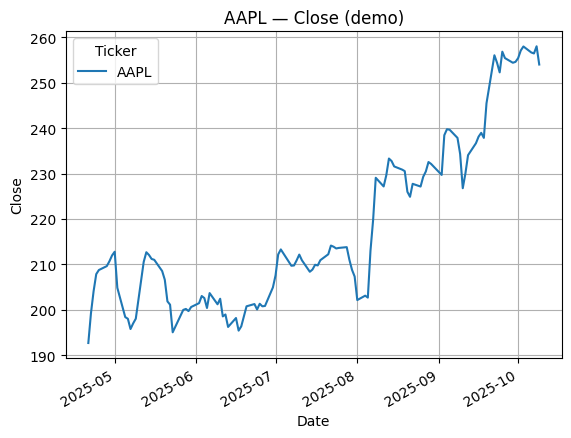

In [575]:
   
# Plot with matplotlib: single plot, default colors
px = None
try:
    # If using fallback DataAgent, we don't have it here, so fetch again
    if USING_FALLBACK:
        # Recompute prices like MarketTool.prices
        if HAS_YF:
            df = yf.download(TICKER, period=f"{CFG['price_history']['window_days']}d")
            if not df.empty:
                px = df["Close"]
        if px is None:
            dates = pd.date_range(end=pd.Timestamp.today(), periods=CFG['market']['window_days'])
            close = 100 + np.cumsum(np.random.randn(CFG['price_history']['window_days']))*0.5
            px = pd.Series(close, index=dates)
    else:
        # If real project is imported, we can't directly access DataAgent here; so just try yfinance or dummy
        if HAS_YF:
            df = yf.download(TICKER, period=f"{CFG['price_history']['window_days']}d")
            if not df.empty:
                px = df["Close"]
        if px is None:
            dates = pd.date_range(end=pd.Timestamp.today(), periods=CFG['price_history']['window_days'])
            close = 100 + np.cumsum(np.random.randn(CFG['price_history']['window_days']))*0.5
            px = pd.Series(close, index=dates)
except Exception:
    dates = pd.date_range(end=pd.Timestamp.today(), periods=CFG['price_history']['window_days'])
    close = 100 + np.cumsum(np.random.randn(CFG['price_history']['window_days']))*0.5
    px = pd.Series(close, index=dates)

plt.figure()
px.plot()
plt.title(f"{TICKER} — Close (demo)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.show()


## 6) What to discuss in class

- How **Prompt Chaining** separates ingest → clean → classify → extract → summarize
- How **Routing** sends content to earnings vs macro analyzers
- How the **Evaluator→Optimizer** loop guards quality (and how you'd expand checks)
- How to replace placeholders with real data (yfinance, EDGAR, a news API)
- How to extend the **backtest** to N past earnings with basic rules and guardrails
